In [ ]:
pip install mne

### Importing Libraries

In [ ]:
import mne
# Importing numpy 
import numpy as np
# Importing Scipy 
import scipy as sp
# Importing Pandas Library 
import pandas as pd
# import glob function to scrap files path
from glob import glob
# import display() for better visualitions of DataFrames and arrays
from IPython.display import display
# import pyplot for plotting
import matplotlib.pyplot as plt
import math
from skimage.restoration import denoise_wavelet
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import seaborn as sns
import pywt

### Importing the data of one subject to test the working of MNE in dealing with EDF files. 

In [ ]:
raw1=mne.io.read_raw_edf('Subject00_1.edf',preload=True) #read the raw eeg signal and store it in variable raw1

,RAW
0,129
1,-89
2,-379
3,-408
4,-124


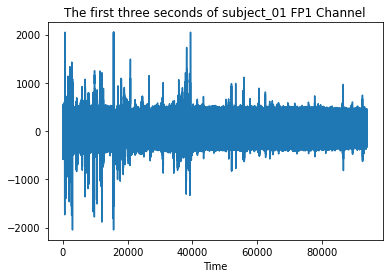

In [ ]:
d_frame=pd.read_csv('/content/Subject00_0.csv')        
d_frame.drop(columns='TimeDate',inplace=True)          # converting the raw file to data frame
plt.plot(d_frame['RAW'][0:])           # visualizing the first 10000 values of channel ECG ECG 
plt.xlabel('Time')
plt.title('The first three seconds of subject_01 FP1 Channel')
d_frame.head()


Text(0.5, 1.0, 'The Distribution of the EEG FP1 ')

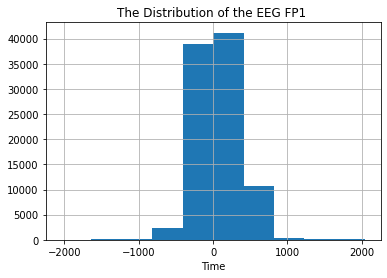

In [ ]:
d_frame['RAW'].hist()
plt.xlabel('Time')
plt.title('The Distribution of the EEG FP1 ')

In [ ]:
Raw_data_paths = sorted(glob("/content/drive/MyDrive/EEG_Graduation/*"))

In [ ]:
len(Raw_data_paths)

5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
raw_dic={}                                   
for path_index in range(6):
  key= Raw_data_paths[path_index][-15:-4]
  #raw=mne.io.read_raw_edf(Raw_data_paths[path_index],preload=True)
  #picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False,stim=False, exclude='bads')
  data_frame=pd.read_csv(Raw_data_paths[path_index])
  data_frame.drop(columns='TimeDate',inplace=True) 
  raw_dic[key]=data_frame

In [ ]:
# raw_dic is a dictionary contains 61 DF
print('raw_dic contains %d DataFrame' % len(raw_dic))

# print the first 3 rows of dataframe exp01_user01
raw_dic['Subject00_0']

raw_dic contains 5 DataFrame


,RAW
0,129
1,-89
2,-379
3,-408
4,-124
...,...
94130,18
94131,-246
94132,-169
94133,76


In [ ]:
number_of_channels= raw_dic['Subject00_0'].shape[1]
number_of_channels

1

In [ ]:
names_of_channels=raw_dic['Subject01_1'].columns
names_of_channels

Index(['RAW'], dtype='object')

### Defining filters 

In [ ]:
#band pass filter between 0.5 and 40 hz
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
from scipy.signal import medfilt # import the median filter function
def median(signal):# input: numpy array 1D (one column)
    array=np.array(signal)   
    #applying the median filter
    med_filtered=sp.signal.medfilt(array, kernel_size=3) # applying the median filter order3(kernel_size=3)
    return  med_filtered # return the med-filtered signal: numpy array 1D

In [ ]:
#notch filter apllied at 50hz
def Implement_Notch_Filter(time, band, freq, ripple, order, filter_type, data):
    from scipy.signal import iirfilter
    fs   = 1/time
    nyq  = fs/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq
    high = high/nyq
    b, a = iirfilter(order, [low, high], rp=ripple, btype='bandstop',
                     analog=False, ftype=filter_type)
    filtered_data = lfilter(b, a, data)
    return filtered_data

### Applying filters and denoising on a sample data

In [ ]:
time_sample_df=pd.DataFrame()
for column in d_frame.columns:
  t_signal=np.array(d_frame[column]) # copy the signal values in 1D numpy array
  med_filtred=median(t_signal) # apply 3rd order median filter and store the filtred signal in med_filtred
  fs = 50.0
  lowcut = 0.5
  highcut = 40
  band_pass=butter_bandpass_filter(med_filtred, lowcut, highcut, fs, order=5)
  notch=Implement_Notch_Filter(0.02, 1, 50, 1, 2, 'butter',band_pass)
  wavelet_denoise=denoise_wavelet(notch,method='BayesShrink',mode='hard',wavelet='sym9',wavelet_levels=5,rescale_sigma=True)
  clean_signals=savgol_filter(wavelet_denoise, 1111, 3,mode='wrap')
  time_sample_df[column]=clean_signals

In [ ]:
from scipy.signal import freqz
t=d_frame['time'][0:1000]
x=d_frame['EEG Fp1'][0:1000]
fs = 50.0
lowcut = 0.5
highcut = 50.0
b, a = butter_bandpass(lowcut, highcut, fs, order=5)
w, h = freqz(b, a, worN=2000)
plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % 5)
plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],'--', label='sqrt(0.5)')
             
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')
a=0.02
plt.figure(2)
plt.clf()
plt.plot(t, x, label='Noisy signal')
y = butter_bandpass_filter(x, lowcut, highcut, fs, order=5)
plt.plot(t, y, label='Filtered signal (%g Hz)' % 500)
plt.xlabel('time (seconds)')
plt.hlines([-a, a], 0, 0.05, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.plot(d_frame['EEG F3'])
plt.title('Before filtering and denoising ')
plt.figure()
plt.plot(time_sample_df['EEG F3'])
plt.title('Clean Signal')


### Generating clean time domian signals of all data 

In [ ]:
for column in raw_df.columns[1:]:
  print(column)

In [ ]:
time_sig_dic={} # An empty dictionary will contains dataframes of all time domain signals
raw_dic_keys=sorted(raw_dic.keys()) # sorting dataframes' keys
for key in raw_dic_keys:
  raw_df=raw_dic[key]
  time_sig_df=pd.DataFrame()
  for column in raw_df.columns:
    t_signal=np.array(raw_df[column]) # copie the signal values in 1D numpy array
    med_filtred=median(t_signal) # apply 3rd order median filter and store the filtred signal in med_filtred
    fs = 50
    lowcut = 0.05
    highcut = 5
    band_pass=butter_bandpass_filter(med_filtred, lowcut, highcut, fs, order=5)
    #notch=Implement_Notch_Filter(0.02, 1, 50, 1, 2, 'butter',band_pass)
    wavelet_denoise=denoise_wavelet(band_pass,method='BayesShrink',mode='hard',wavelet='sym9',wavelet_levels=5,rescale_sigma=True)
    clean_signals=savgol_filter(wavelet_denoise, 1111, 3,mode='wrap')
    time_sig_df[column]=clean_signals
    time_sig_dic[key]=time_sig_df

In [ ]:
########################################################################################
# Here I wanted to generate a df for the time length of each EEG record MNE library to:#                                       #
########################################################################################
time_list=[]
for i in range(5):
  time=(time_sig_dic[Raw_data_paths[i][-15:-4]].index.values[-1])
  time_list.append(time)
data=np.array(time_list)
time_length=pd.DataFrame(data=data,columns=['Signl length'])
time_length

,Signl length
0,94134
1,98644
2,97153
3,98767
4,98543


In [ ]:
# example: 679 ==> '00679'; 50 ==> '00050'

# it add '0's to the left of the input until the new lenght is equal to 5
def normalize5(number): 
    stre=str(number)
    if len(stre)<5:
        l=len(stre)
        for i in range(0,5-l):
            stre="0"+stre
    return stre 

# it add '0's to the left of the input until the new lenght is equal to 2
def normalize2(number):
    stre=str(number)
    if len(stre)<2:
        stre="0"+stre
    return stre

In [ ]:
for sig_time in range(0,len(time_length)):
  sig_time_length=(time_length['Signl length'][sig_time])
  print(sig_time_length)

94134
98644
97153
98767
98543


In [ ]:
time_sig_dic['Subject00_0'].columns[0]

'RAW'

In [ ]:
window_dict={} 
#window_ID=0                           #A dict that will contain all windows
columns=time_sig_dic['Subject02_0'].columns
for subject_id , state in zip([0,1,2,3,4],[0,1,0,1,0]):
  file_key= 'Subject' + normalize2(int(subject_id))  +  '_' + str(state)
  print(file_key)
  dic_update=raw_dic[file_key]
  for sig_time in range(0,len(time_length)):

    sig_time_length=(time_length['Signl length'][sig_time])
    window_ID=0
    for cursor in range(0,(sig_time_length-199),50):
      end_point=cursor+200
      data=np.array(dic_update.iloc[cursor:end_point])
      window=pd.DataFrame(data=data,columns=columns)
      key='t_W'+normalize5(window_ID)+'_'+file_key
      window_dict[key]=window
      wind_dic=window_dict[key]
      window_ID=window_ID+1
  


Subject00_0
Subject01_1
Subject02_0
Subject03_1
Subject04_0


In [ ]:
new_frames = {k:v for (k,v) in window_dict.items() if not v.empty}

In [ ]:
len(new_frames)

9742

In [ ]:
sorted(new_frames.keys())[0]

't_W00000_Subject00_0'

### Frequency domain 

In [ ]:
#Fourier transform function 
from scipy import fftpack # import fftpack to use all fft functions
from numpy.fft import *
##################### fast_fourier_transform_one_signal #################
# Inputs: time signal 1D array
# Output: amplitude of fft components 1D array having the same lenght as the Input
def fast_fourier_transform_one_signal(t_signal):
    # apply fast fourrier transform to the t_signal
    complex_f_signal= fftpack.fft(t_signal)
    #compute the amplitude each complex number
    amplitude_f_signal=np.abs(complex_f_signal)
    # return the amplitude
    return amplitude_f_signal
##################### fast fourier transform for data frames #################
def fast_fourier_transform(t_window):
  f_window=pd.DataFrame() # create an empty dataframe will include frequency domain signals of window
  for column in t_window.columns: 
    t_signal=np.array(t_window[column]) # convert the column to a 1D numpy array
    f_signal= np.apply_along_axis(fast_fourier_transform_one_signal,0,t_signal) # apply the function defined above to the column
    f_window["freq_"+column[0:]]=f_signal # storing the frequency signal in f_window with an appropriate column name
  return f_window # return the frequency domain window

In [ ]:
f_window_dict = {'f'+key[1:] : t_w1_df.pipe(fast_fourier_transform) for key, t_w1_df in new_frames.items()}

In [ ]:
fnew_frames = {k:v for (k,v) in f_window_dict.items() if not v.empty}

In [ ]:
len(fnew_frames)

9742

In [ ]:
def tf(t_freq_signal):
  (cA, cD) = pywt.dwt(t_freq_signal, 'db1')
  x=np.concatenate((cD,cA),axis=0)
  return x

In [ ]:
time_freq_dic={}
time_dic_keys=sorted(new_frames.keys())
for k in time_dic_keys:
  time_df=new_frames[k]
  time_freq_df=pd.DataFrame()
  for c in time_df.columns:
    t_freq_signal=np.array(time_df[c])
    sum_of_coff=np.apply_along_axis(tf,0,t_freq_signal)
    time_freq_df['time_freq'+c]=sum_of_coff
    time_freq_dic[k]=time_freq_df

In [ ]:
time_freq_dic['t_W00000_Subject00_0']
time_freq_dic['t_W00000_Subject00_0'].columns[0]

'time_freqRAW'

In [ ]:
t_f_newframes = {k:v for (k,v) in time_freq_dic.items() if not v.empty}

In [ ]:
t_f_newframes['t_W00000_Subject00_0']

,time_freqRAW
0,154.149278
1,20.506097
2,-282.842712
3,61.518290
4,67.175144
...,...
195,233.345238
196,614.475793
197,193.747258
198,-268.700577


In [ ]:
tr=new_frames['t_W00000_Subject00_0']
f_all_axial_features=[]
#df=axial_df  
mean_vector   = list(mean_axial(tr)) # 3values
std_vector    = list(std_axial(tr)) # 3 values
mad_vector    = list(mad_axial(tr))# 3 values
max_vector    = list(max_axial(tr))# 3 values
min_vector    = list(min_axial(tr))# 3 values
IQR_vector    = list(IQR_axial(tr))# 3 values
entropy_vector= list(entropy_axial(tr))# 3 values
energy_vector                = list(f_energy_axial(tr))
skewness_and_kurtosis_vector = f_skewness_and_kurtosis_axial(tr)# 6 values
f_3axial_features =  mean_vector +std_vector + mad_vector+max_vector+min_vector+  energy_vector + IQR_vector + entropy_vector +  skewness_and_kurtosis_vector  
f_all_axial_features = f_all_axial_features+ f_3axial_features # add features to the global list
f_all_axial_features

In [ ]:
# df is dataframe contains 3 columns (3 axial signals X,Y,Z)

# mean
def mean_axial(df):
    array=np.array(df) # convert dataframe into 2D numpy array for efficiency
    mean_vector = array.mean(axis=0) # calculate the mean value of each column
    return mean_vector # return mean vetor
# std
def std_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    std_vector =array.std(axis=0)# calculate the standard deviation value of each column
                     
    return std_vector

# mad
from statsmodels.robust import mad as median_deviation # import the median deviation function
def mad_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    mad_vector = median_deviation(array,axis=0) # calculate the median deviation value of each column
    return mad_vector

# max

def max_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    max_vector=array.max(axis=0)# calculate the max value of each column
    return max_vector
# min
def min_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    min_vector=array.min(axis=0)# calculate the min value of each column
    return min_vector
# IQR
from scipy.stats import iqr as IQR # import interquartile range function (Q3(column)-Q1(column))
def IQR_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    IQR_vector=np.apply_along_axis(IQR,0,array)# calculate the inter quartile range value of each column
    return IQR_vector


# Entropy
from scipy.stats import entropy # import the entropy function
def entropy_axial(df):
    array=np.array(df)# convert dataframe into 2D numpy array for efficiency
    entropy_vector=np.apply_along_axis(entropy,0,abs(array))# calculate the entropy value of each column
    return entropy_vector

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pip install spectrum

In [ ]:
# energy
def t_energy_axial(df):
    array=np.array(df)
    energy_vector=(array**2).sum(axis=0) # energy value of each df column
    return energy_vector # return energy vector energy_X,energy_Y,energy_Z

In [ ]:
#Time Features PipeLine
def t_axial_features_generation(t_window):
  axial_columns=t_window.columns[0]
  axial_df=t_window[axial_columns]
  t_axial_features=[]
  df=axial_df  
  mean_vector   = list(mean_axial(t_window)) 
  std_vector    = list(std_axial(t_window)) 
  mad_vector    = list(mad_axial(t_window))
  max_vector    = list(max_axial(t_window))
  min_vector    = list(min_axial(t_window))
  energy_vector = list(t_energy_axial(t_window))
  IQR_vector    = list(IQR_axial(t_window))
  entropy_vector= list(entropy_axial(t_window))
  # 40 value per each 3-axial signals
  t_3axial_vector= mean_vector + std_vector + mad_vector + max_vector + min_vector + energy_vector + IQR_vector + entropy_vector 
  t_axial_features= t_axial_features+ t_3axial_vector
  return t_axial_features

In [ ]:
for x in [['eeg'],]:
  for n in x:
    print(n)

eeg


In [ ]:
def time_features_names():
    # Generating time feature names
    t_axis_signals=[['EEG '],]
    # functions' names:
    t_one_input_features_name1=['_mean()','_std()','_mad()','_max()','_min()']
    t_one_input_features_name2=['_energy()','_iqr()','_entropy()']
    features=[]# Empty list : it will contain all time domain features' names
    for columns in t_axis_signals: # iterate throw  each group of 3-channels'        
        for feature in t_one_input_features_name1: # iterate throw the first list of functions names            
            for column in columns: # iterate throw each axial signal in that group              
                newcolumn=column+feature # build the feature name
                features.append(newcolumn) # add it to the global list
        for feature in t_one_input_features_name2: # same process for the second list of features functions
            for column in columns:
                newcolumn=column+feature
                features.append(newcolumn)         
    ###########################################################################################################
    time_list_features=features
    
    return time_list_features # return all time domain features' names

In [ ]:
#Frequency Features 
def f_energy_axial(df):
    
    array=np.array(df)
    
    # spectral energy vector
    energy_vector=(array**2).sum(axis=0)/float(len(array))
    
    return energy_vector 
########## Skewness & Kurtosis Functions #######################################
from scipy.stats import kurtosis       # kurtosis function
from scipy.stats import skew           # skewness function
    
def f_skewness_and_kurtosis_axial(df):
    array=np.array(df)
    
    skew_X= skew(array)  
    kur_X= kurtosis(array)  
    
    #skew_Y= skew(array[:,1]) 
    #kur_Y= kurtosis(array[:,1])
    
    #skew_Z= skew(array[:,2])
    #kur_Z= kurtosis(array[:,2])
    
    skew_kur_3axial_vector=[skew_X,kur_X]  #,skew_Y,kur_Y,skew_Z,kur_Z] 
    
    return skew_kur_3axial_vector

In [ ]:
sk=10
ku=15
dddd=[10,15]
dddd

[10, 15]

In [ ]:
#Time_freq features
def t_f_skewness_and_kurtosis_axial(df):
    array=np.array(df)
    
    skew_X= skew(array)  
    kur_X= kurtosis(array)  
    
    #skew_Y= skew(array[:,1]) 
    #kur_Y= kurtosis(array[:,1])
    
    #skew_Z= skew(array[:,2])
    #kur_Z= kurtosis(array[:,2])
    
    skew_kur_3axial_vector=[skew_X,kur_X]#,skew_Y,kur_Y,skew_Z,kur_Z] 
    
    return skew_kur_3axial_vector


In [ ]:
for x in range(1):
  print(x)

0


In [ ]:
def f_axial_features_generation(f_window):


  axial_columns=f_window.columns[0]
  axial_df=f_window[axial_columns] 
  f_all_axial_features=[] 
  df=axial_df     
  mean_vector   = list(mean_axial(f_window)) # 3values
  std_vector    = list(std_axial(f_window)) # 3 values
  mad_vector    = list(mad_axial(f_window))# 3 values
  max_vector    = list(max_axial(f_window))# 3 values
  min_vector    = list(min_axial(f_window))# 3 values
  IQR_vector    = list(IQR_axial(f_window))# 3 values
  entropy_vector= list(entropy_axial(f_window))# 3 values
  energy_vector                = list(f_energy_axial(f_window))
  skewness_and_kurtosis_vector = f_skewness_and_kurtosis_axial(f_window)# 6 values
  f_3axial_features =  mean_vector +std_vector + mad_vector+max_vector+min_vector+  energy_vector + IQR_vector + entropy_vector +  skewness_and_kurtosis_vector  
  f_all_axial_features = f_all_axial_features+ f_3axial_features # add features to the global list
  return f_all_axial_features

In [ ]:
def t_f_axial_features_generation(t_f_window):
  axial_columns=t_f_window.columns[0]
  axial_df=t_f_window[axial_columns] 
  t_f_all_axial_features=[] 
  df=axial_df    
  mean_vector   = list(mean_axial(t_f_window)) # 3values
  std_vector    = list(std_axial(t_f_window)) # 3 values
  mad_vector    = list(mad_axial(t_f_window))# 3 values
  max_vector    = list(max_axial(t_f_window))# 3 values
  min_vector    = list(min_axial(t_f_window))# 3 values
  IQR_vector    = list(IQR_axial(t_f_window))# 3 values
  entropy_vector= list(entropy_axial(t_f_window))# 3 values
  #energy_vector                = f_energy_axial(df)
  skewness_and_kurtosis_vector = t_f_skewness_and_kurtosis_axial(t_f_window)# 6 values
  f_3axial_features =  mean_vector +std_vector + mad_vector+max_vector+min_vector+  IQR_vector + entropy_vector +  skewness_and_kurtosis_vector  
  t_f_all_axial_features = t_f_all_axial_features+ f_3axial_features # add features to the global list
  return t_f_all_axial_features

In [ ]:
def frequency_features_names():
    axial_signals=[['EEG ']]
    # features functions names will be applied to f_signals
    f_one_input_features_name1=['_mean()','_std()','_mad()','_max()','_min()']
    f_one_input_features_name2=['_energy()','_iqr()','_entropy()']
    f_one_input_features_name3= ['_skewness()','_kurtosis()']    
    frequency_features_names=[] # global list of frequency features
    for columns in axial_signals: # iterate throw each group of 3-axial signals
        # iterate throw the first list of features
        for feature in f_one_input_features_name1: 
            for column in columns:# iterate throw each signal name of that group
                newcolumn=column+feature # build the full feature name
                frequency_features_names.append(newcolumn) # add the feature name to the global list
        # iterate throw the first list of features
        for feature in f_one_input_features_name2:
            for column in columns:
                newcolumn=column+feature
                frequency_features_names.append(newcolumn)
        # iterate throw each signal name of that group
        for column in columns:
            for feature in f_one_input_features_name3: # iterate throw [skewness ,kurtosis]
                newcolumn=column+feature # build full feature name
                frequency_features_names.append(newcolumn) # append full feature names#
    return frequency_features_names

In [ ]:
def t_frequency_features_names():
    axial_signals=[['EEG ']]
    # features functions names will be applied to f_signals
    f_one_input_features_name1=['_mean()','_std()','_mad()','_max()','_min()']
    f_one_input_features_name2=['_iqr()','_entropy()']
    f_one_input_features_name3= ['_skewness()','_kurtosis()']    
    time_frequency_features_names=[] # global list of frequency features
    for columns in axial_signals: # iterate throw each group of 3-axial signals
        # iterate throw the first list of features
        for feature in f_one_input_features_name1: 
            for column in columns:# iterate throw each signal name of that group
                newcolumn=column+feature # build the full feature name
                time_frequency_features_names.append(newcolumn) # add the feature name to the global list
        # iterate throw the first list of features
        for feature in f_one_input_features_name2:
            for column in columns:
                newcolumn=column+feature
                time_frequency_features_names.append(newcolumn)
        # iterate throw each signal name of that group
        for column in columns:
            for feature in f_one_input_features_name3: # iterate throw [skewness ,kurtosis]
                newcolumn=column+feature # build full feature name
                time_frequency_features_names.append(newcolumn) # append full feature names#
    return time_frequency_features_names

In [ ]:
for ind in range(len(new_frames)):
  tk=sorted(new_frames.keys())[ind]
  t_window=new_frames[tk]
  window_user_id= int(tk[-4:-2])
  #print(t_window)
  window_activity_id=int(tk[-1])
  zz=t_axial_features_generation(t_window)
  

In [ ]:
zz

[69.19,
 42.209523806837716,
 38.54765768114565,
 204,
 -39,
 1313780,
 50.25,
 5.146275471886081]

In [ ]:
ssss

array([], dtype=float64)

In [ ]:
# conctenate all features names lists and we add two other columns state and subject will be related to each row
all_columns=time_features_names()+frequency_features_names()+t_frequency_features_names()+['state','subject']
def Dataset_Generation_PipeLine(t_dic,f_dic,t_f_dic):
    # t_dic is a dic contains time domain windows
    final_Dataset=pd.DataFrame(data=[],columns= all_columns) # build an empty dataframe to append rows
    for i in range(len(t_dic)): # iterate throw each window
        # t_window and f_window should have the same window id included in their keys
        t_key=sorted(t_dic.keys() )[i] # extract the key of t_window 
        f_key=sorted(f_dic.keys() )[i] # extract the key of f_window
        t_f_key=sorted(t_f_dic.keys() )[i]
        t_window=t_dic[t_key] # extract the t_window
        f_window=f_dic[f_key] # extract the f_window
        t_f_window=t_f_dic[t_f_key]

        window_user_id= int(t_key[-4:-2]) # extract the user id from window's key
        window_activity_id=int(t_key[-1]) # extract the activity id from the windows key
        # generate all time features from t_window 
        time_features = t_axial_features_generation(t_window) 
        frequency_features = f_axial_features_generation(f_window)
        time_freq_features=t_f_axial_features_generation(t_f_window)
        # concatenate all features and append the activity id and the user id
        row= time_features +frequency_features+time_freq_features+ [int(window_activity_id),int(window_user_id)]
        # go to the first free index in the dataframe
        free_index=len(final_Dataset)
        # append the row
        final_Dataset.loc[free_index]= row  
    return final_Dataset # return the final dataset

In [ ]:
Dataset= Dataset_Generation_PipeLine(new_frames,fnew_frames,t_f_newframes)

In [ ]:
print('The shape of Dataset is :',Dataset.shape) # shape of the dataset 
display(Dataset.describe()) # statistical description
display(Dataset.head(10)) # the first three rows

The shape of Dataset is : (9742, 29)


,EEG _mean(),EEG _std(),EEG _mad(),EEG _iqr(),EEG _entropy(),EEG _mean(),EEG _std(),EEG _mad(),EEG _max(),EEG _min(),EEG _energy(),EEG _iqr(),EEG _entropy(),EEG _mean(),EEG _std(),EEG _mad(),EEG _max(),EEG _min(),EEG _iqr(),EEG _entropy()
count,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9.742000e+03,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000,9742.000000
mean,49.241710,295.587689,343.231317,526.397018,5.116119,1760.970647,3932.927117,443.320742,31075.504015,110.657421,2.398388e+07,1263.131422,4.283873,34.813053,300.699405,267.735395,674.846468,-647.880528,360.870425,4.930832
std,38.223876,169.460790,192.227469,313.853300,0.075125,945.188146,2126.527087,253.114241,15713.431045,132.062612,2.247790e+07,663.822093,0.161942,27.057895,166.164376,162.535599,329.341130,405.786094,210.348426,0.132325
min,-384.815000,18.220867,20.756431,27.250000,1.382603,227.336213,336.302670,32.042736,848.000000,0.000000,1.757440e+05,88.801650,0.461368,-273.070497,29.423901,16.773729,33.941125,-2896.309376,22.273864,0.736067
25%,41.880000,192.234805,234.251151,351.250000,5.088626,1151.805410,2565.401461,220.332282,19264.033253,18.969379,7.936293e+06,821.234226,4.193544,29.410339,195.939657,169.309830,474.645427,-952.296058,231.931024,4.931767
50%,49.390000,267.748566,344.705016,470.750000,5.135806,1704.452661,3490.082241,456.662347,30200.740009,57.615504,1.490363e+07,1243.695925,4.303921,34.938146,270.624859,241.646538,659.023520,-545.886435,296.631295,4.985553
75%,56.678750,436.757096,513.721669,790.000000,5.156964,2534.339893,5691.912332,620.080933,42721.707708,152.722280,3.885157e+07,1723.967530,4.390913,40.262660,438.834741,397.327713,914.996175,-417.193001,548.007755,5.003716
max,630.265000,1289.697303,1667.186195,2399.250000,5.253676,6231.930604,17346.809698,1650.271519,151308.660491,952.794316,3.363288e+08,3883.131714,4.812922,445.236856,1293.332000,757.438715,2894.895162,-5.656854,1005.152289,5.080047


,EEG _mean(),EEG _std(),EEG _mad(),EEG _max(),EEG _min(),EEG _energy(),EEG _iqr(),EEG _entropy(),EEG _mean(),EEG _std(),EEG _mad(),EEG _max(),EEG _min(),EEG _energy(),EEG _iqr(),EEG _entropy(),EEG _skewness(),EEG _kurtosis(),EEG _mean(),EEG _std(),EEG _mad(),EEG _max(),EEG _min(),EEG _iqr(),EEG _entropy(),EEG _skewness(),EEG _kurtosis(),state,subject
0,52.430,258.690733,330.620295,556,-587,13933960,438.00,5.075521,2165.547123,3040.454844,868.221405,21313.663472,89.408300,13933960.0,2428.431654,4.705440,[3.8714654343446675],[18.90574346448087],37.533228,261.268170,253.702656,657.609307,-781.352993,268.700577,4.978994,[0.23563205449993696],[0.2567534212600533],0,0
1,61.125,552.757053,661.981891,950,-982,61855325,940.00,5.118838,3342.727579,7119.093856,856.831442,49845.736802,290.723430,61855325.0,2774.168882,4.351935,[5.089800176301202],[28.074202098985843],45.028560,554.300509,495.873373,1155.412480,-1288.348555,654.604103,5.004412,[-0.09053293193368092],[-0.2438310636097314],1,1
2,42.820,254.083781,303.192154,451,-475,13278424,468.50,5.150551,1821.133173,3156.247450,800.006376,27396.273863,92.439887,13278424.0,1641.445938,4.605368,[5.789965933875601],[41.47527756610374],26.778134,256.271441,229.590420,607.404725,-531.744299,312.364421,4.990480,[0.04465196580456052],[-0.45158065412989945],0,2
3,36.405,55.646572,58.562788,212,-135,884373,76.25,5.015599,537.079691,771.957515,254.075703,7281.000000,40.169842,884373.0,502.879029,4.722169,[4.8090272374438285],[32.57728753146926],24.932585,61.646015,31.974922,275.771645,-140.007143,67.528698,4.749479,[0.763601574461734],[1.458633910614151],1,3
4,39.090,328.835281,372.874458,504,-643,21932134,595.00,5.168024,1841.607707,4305.881449,448.692898,29784.745076,59.488466,21932134.0,1464.972775,4.191696,[5.058536103290915],[27.689217782155357],26.530646,330.086042,322.370110,685.186471,-831.557575,428.329933,4.965934,[-0.25973713527909137],[-0.30126908954078324],0,4
5,87.425,235.291531,312.087767,556,-296,12601047,430.75,5.070777,1308.423552,3299.859817,534.938154,28682.845620,11.000000,12601047.0,1125.651711,4.194917,[6.516250175389931],[47.757907321972276],61.779919,243.286820,231.687136,671.751442,-393.151370,266.756033,4.971693,[0.6542085813972576],[-0.11935998060420339],0,0
6,55.950,562.119674,678.290515,887,-982,63821786,974.75,5.122006,3101.931665,7362.051748,766.119694,55891.468356,176.908324,63821786.0,2808.826218,4.163486,[5.213606294739486],[30.301988043075525],38.685812,563.571058,495.349194,1178.039897,-1288.348555,676.170860,5.018999,[-0.1054533654730595],[-0.3220486565778522],1,1
7,41.120,251.883595,300.226949,405,-475,13027240,469.50,5.154790,1518.355414,3274.421603,448.270038,24034.284845,137.486893,13027240.0,994.819705,4.370239,[5.167072335174695],[28.908199322197316],26.622570,253.825607,233.259673,546.593542,-513.359523,314.132188,5.013378,[-0.011896383552453354],[-0.5710498877700982],0,2
8,96.825,100.890457,94.145241,400,-67,3910793,157.00,4.913140,727.520745,1838.887317,224.766044,19365.000000,33.296395,3910793.0,497.044989,4.194627,[6.724277627550813],[55.871430125894555],68.235804,122.056708,42.982681,526.794552,-79.903066,119.324269,4.521686,[1.7564010321011125],[2.433063930047842],1,3
9,93.695,354.490130,358.789737,761,-643,26888401,587.75,5.158286,2293.042855,4650.844597,346.028671,32948.822249,397.647657,26888401.0,1415.879376,4.359102,[4.469583561914347],[22.69085162064502],67.776185,360.344826,314.507425,1043.689609,-831.557575,414.894904,4.936059,[0.10511065250001589],[-0.016953576147273886],0,4


In [ ]:
# divide datasets type I and II in two parts to reduce the size for github uploading
# Define paths and files' names
path1="/content/drive/MyDrive/Graduation_data/Graduation_01.csv" 
#Export all part into a CSV form in : "New Data\\full_Datasets_type_I_and_II\"
Dataset.to_csv(path_or_buf=path1, na_rep='NaN',  
             columns=None, header=True, 
             index=False, mode='w', 
             encoding='utf-8',  
             line_terminator='\n', 
             )